Here we will look at some aggregations over specific start and stop locations. Going from point A to point B is a 'trip'.

Grouping statistics by trip can cut the data size by a large amount, as the number of trips:
${n \choose 2}^2 $ (choosing pickups and dropoffs). 

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
sns.set()

from datetime import datetime, timedelta

from Fair_Fare.feature_utils import load_hdf
from Fair_Fare.aggregations import bin_on_trips
from Fair_Fare.model_utils import get_model_from_file, predict_fare
from Fair_Fare.trips import Stop, Ride

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [212]:
models = {"path":"models/", "taxi":"taxi_xgb_full", "rideshare":"tnp_xgb_full_reduced_params" }
data = {"path":"data/","taxi":"taxi_test.h5", "rideshare":"tnp_train.h5" }

taxi_model = get_model_from_file(models['path']+models['taxi'])
taxi_data = load_hdf(data['path']+data['taxi'])

rideshare_model = get_model_from_file(models['path']+models['rideshare'])
rideshare_data = load_hdf(data['path']+data['rideshare'])

So there are about 900 unique lat/longs giving ~ 500k trip combinations.

#### Grouping by rides:

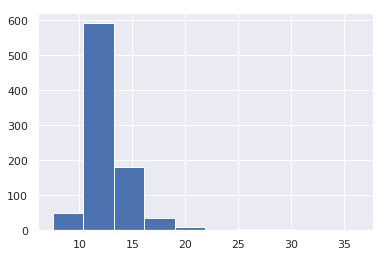

In [213]:
binned = bin_on_trips(rideshare_data)
binned.df.groupby(["Pickup_Centroid_Latitude","Pickup_Centroid_Longitude"]).Final_Fare.mean().hist()

In [214]:
# total unique trips with binning after the cut
binned.cut_along_lat_long()
print(binned.total_unique_paths)
trip_df = binned.df.groupby('path')

20253


In [172]:
trip_df.head()

,Trip_Seconds,Trip_Miles,Pickup_Community_Area,Dropoff_Community_Area,Shared_Trip_Authorized,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,vel_mph,...,y_dist_km,bearing,bAirport,day_of_wk,hour,Pickup_Centroid_Latitude_b,Dropoff_Centroid_Latitude_b,Pickup_Centroid_Longitude_b,Dropoff_Centroid_Longitude_b,path
6283605,1913.0,6.700000,77.0,22.0,False,41.985472,-87.653794,41.929330,-87.711974,12.608468,...,6.242793,-142.361378,False,5,0,17,14,12,9,"((17, 12), (14, 9))"
10327851,1335.0,5.400000,7.0,32.0,False,41.929078,-87.646293,41.880994,-87.632746,14.561798,...,5.346614,168.152913,False,1,8,14,11,13,13,"((14, 13), (11, 13))"
581229,1560.0,5.300000,6.0,28.0,False,41.934540,-87.643023,41.878667,-87.671654,12.230769,...,6.212725,-159.115063,False,6,14,14,11,13,11,"((14, 13), (11, 11))"
10148217,590.0,5.900000,44.0,68.0,False,41.740206,-87.615970,41.777196,-87.642498,36.000000,...,4.113162,-28.136520,False,1,22,4,6,14,13,"((4, 14), (6, 13))"
1776825,1126.0,4.800000,6.0,4.0,True,41.944227,-87.655998,41.975171,-87.687516,15.346359,...,3.440859,-37.129196,False,3,15,15,16,12,11,"((15, 12), (16, 11))"
15427863,748.0,5.400000,3.0,8.0,False,41.965812,-87.655879,41.899602,-87.633308,25.989305,...,7.362211,165.762051,False,6,5,16,12,12,13,"((16, 12), (12, 13))"
2774086,916.0,2.100000,24.0,28.0,False,41.899670,-87.669838,41.885300,-87.642808,8.253275,...,1.597891,125.525432,False,0,7,12,12,12,13,"((12, 12), (12, 13))"
11874887,671.0,3.500000,8.0,24.0,False,41.907492,-87.635760,41.900560,-87.694197,18.777943,...,0.770754,-99.035690,False,5,1,13,12,13,10,"((13, 13), (12, 10))"
1462115,168.0,0.300000,6.0,6.0,True,41.942692,-87.651771,41.946295,-87.654298,6.428572,...,0.400602,-27.556070,False,5,6,14,15,12,12,"((14, 12), (15, 12))"
13467561,798.0,2.800000,8.0,28.0,False,41.892508,-87.626215,41.867902,-87.642959,12.631578,...,2.735995,-153.125120,False,2,15,12,11,14,13,"((12, 14), (11, 13))"


TODO: Create a function to plot the route on a map and show this histogram at the same time. Intermediate data product is a histogram for each of these routes.

In [77]:

test_trip = binned.df[binned.df['Final_Fare']>40].iloc[228]
#print(test_trip)
tup = ((test_trip['Pickup_Centroid_Latitude'],test_trip['Pickup_Centroid_Longitude']),
       (test_trip['Dropoff_Centroid_Latitude'],test_trip['Dropoff_Centroid_Longitude']))

assert binned.trip_to_path(tup) == test_trip['path']
print(test_trip)

Trip_Seconds                                   3761
Trip_Miles                                     19.4
Pickup_Community_Area                            33
Dropoff_Community_Area                           76
Shared_Trip_Authorized                        False
Pickup_Centroid_Latitude                    41.8593
Pickup_Centroid_Longitude                  -87.6174
Dropoff_Centroid_Latitude                   41.9791
Dropoff_Centroid_Longitude                  -87.903
vel_mph                                     18.5695
Final_Fare                                     42.5
l2_dist_km                                  27.1279
x_dist_km                                   23.6591
y_dist_km                                   13.3124
bearing                                    -60.5163
bAirport                                      False
day_of_wk                                         4
hour                                             14
Pickup_Centroid_Latitude_b                       10
Dropoff_Cent

We want a function that takes a single ride as input,
outputs the histogram and the prediction.

In [143]:
time = datetime.now()
time = time+ timedelta(hours=int(test_trip["hour"]+24)- time.hour) # replace time with hour tomorrow (gmaps pred must be in future)
ride = Ride(tup[0],tup[1], time = time, bRideshare = True, bShared = False)
predict_fare(ride, rideshare_model)

13.775015678965612 27.172984061071134
24.75999061088577 0.6476825405035734


array([50.357998], dtype=float32)

In [108]:
time = datetime.now()
time = time+ timedelta(hours=int(test_trip["hour"]+24)- time.hour)

In [194]:
def text_to_fares(start, end, bRideshare = True, bShared = False):
    time = datetime.now()
    time = time+ timedelta(hours=int(test_trip["hour"]+24)- time.hour)
    
    ride = Ride(start,end, time, bRideshare, bShared)
    Fair_Fare = predict_fare(ride, rideshare_model)
    lyft_estimates = price_estimate_from_lyft(ride.start.tuple,ride.end.tuple)
    print(ride.path)
    binned_pth = binned.trip_to_path(ride.path)
    print(binned_pth)
    group =  binned.df[binned.df.path == binned_pth]
    return Fair_Fare, lyft_estimates, group

In [208]:
 Fair_Fare, lyft_estimates, group= text_to_fares("chicago ohare", "sears tower")

22.315681329572087 5.830687072657139
13.997724487246801 24.86747089457968
((41.9773265, -87.83689199999999), (41.8780985, -87.6358815))
((16, 3), (11, 13))


In [211]:
print(len(rideshare_data))

3047211


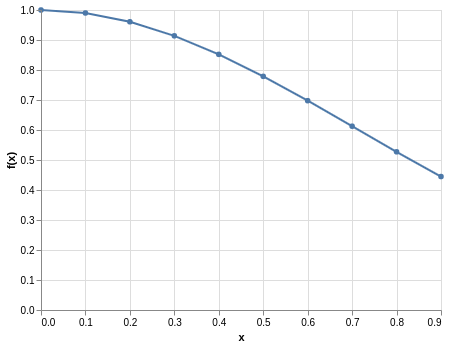

In [137]:
import altair as alt
import numpy as np
import pandas as pd

x = np.arange(10)/10
source = pd.DataFrame({
  'x': x,
  'f(x)': np.exp(-x**2)
})

alt.Chart(source).mark_line(point=True).encode(
    x='x',
    y='f(x)'
)